1. Clustering

Usa el conjunto de datos de las viviendas en California que puedes descargar con la función: sklearn.datasets.fetch_california_housing

En el conjunto de datos cada fila es un “bloque” que es la mínima unidad geográfica para la cual el censo estadounidense hace públicos los datos (suele tener desde varios cientos a unos pocos miles de habitantes). 

El objetivo es realizar agrupamientos de los bloques que presenten características similares. No incluyas la latitud y longitud para no agrupar los bloques por su cercanía geográfica, sino por sus características. Tampoco incluyas la variable target del dataset que es la mediana del precio de las viviendas en el bloque en cuestión. 

In [14]:
import numpy as np
import sklearn
import statistics as stat
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.datasets.samples_generator import make_blobs
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

np.random.seed(11)  

# conjunto de datos de las viviendas en California
# .data, .target, .feature_names, .DESCR
cali = sklearn.datasets.fetch_california_housing()

# descripcion del conjunto
print(cali.DESCR)


.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

Por cada conjunto de datos que utilices deberás incluir una breve descripción del mismo
    - Nombre del conjunto de datos
    - Breve descripción del problema que describe
    - Nombre y tipo de las variables
    - Estadísticos descriptivos de cada variable

1) Describe el conjunto de datos tal y como se indica más arriba y extrae algunas conclusiones de las variables, su distribución y su correlación
   
    - Nombre del conjunto de datos
        California Housing Dataset
        
    - Breve descripción del problema que describe
        Representar bloques de zonas habitables en California de 1990. Un bloque tiene entre 600 y 3.000 personas.

    - Nombre y tipo de las variables
        Proporciona los siguientes datos :
            MedInc    
            HouseAge  
            AveRooms  
            AveBedrms 
            Population
            AveOccup  
            Latitude  
            Longitude 
         
        todas las variables son de tipo numpy.float64
        
    - Estadísticos descriptivos de cada variable
        MedInc     		mediana de los ingresos del bloque
        HouseAge  		mediana de las edades de las casas del bloque
        AveRooms  		número medio de habitaciones
        AveBedrms 		número medio de dormitorios
        Population 		población del bloque
        AveOccup   		media de residentes por vivienda
        Latitude   		latitud del bloque
        Longitude		longitud del bloque
        
       
        


In [15]:
# Distribución de datos 
for j in range(0, 8):
    X = []
    for i in range(0, len(cali.data)):
        X.append(cali.data[i][j])
    
    print(cali.feature_names[j], "(", j, ")")
    print("\tMedia: ", stat.mean(X))
    print("\tDeviación típica: ", stat.stdev(X))
    print("\tVarianza: ", stat.variance(X))
    print("\tMediana: ", stat.median(X))
    print("\tMáximo: ", max(X))    
    print("\tMínimo: ", min(X), "\n")

MedInc ( 0 )
	Media:  3.8706710029069766
	Deviación típica:  1.8998217179452688
	Varianza:  3.6093225599765124
	Mediana:  3.5347999999999997
	Máximo:  15.0001
	Mínimo:  0.4999 

HouseAge ( 1 )
	Media:  28.639486434108527
	Deviación típica:  12.585557612111648
	Varianza:  158.39626040778145
	Mediana:  29.0
	Máximo:  52.0
	Mínimo:  1.0 

AveRooms ( 2 )
	Media:  5.428999742190376
	Deviación típica:  2.4741731394243187
	Varianza:  6.12153272384879
	Mediana:  5.229128787878788
	Máximo:  141.9090909090909
	Mínimo:  0.8461538461538461 

AveBedrms ( 3 )
	Media:  1.096675149606208
	Deviación típica:  0.473910856795466
	Varianza:  0.22459150018861268
	Mediana:  1.048780487804878
	Máximo:  34.06666666666667
	Mínimo:  0.3333333333333333 

Population ( 4 )
	Media:  1425.4767441860465
	Deviación típica:  1132.462121765341
	Varianza:  1282470.4572332578
	Mediana:  1166.0
	Máximo:  35682.0
	Mínimo:  3.0 

AveOccup ( 5 )
	Media:  3.0706551594363742
	Deviación típica:  10.386049562213618
	Varianza:  107

2) Considera si debes re‐escalar las variables antes y el tipo de escalado que usas. Razona tu elección. 

In [16]:
def plot_clusters(X, labels=None, centers=None):
    """ Función auxiliar para pintar los puntos de los clusters y, optativamente, sus centros.
    :param X: array de puntos de dos dimensiones (array de array de enteros)
    :param labels: cluster al que pertenece cada punto (array de enteros)
    :param centers: coordenadas de los centroides de los clusters (array de array de enteros)
    """
    
    colors = ['r','g','b','c','y','k','w','m',]
    fig = plt.figure(figsize=(8,8))
    
    # Los dos primeros parámetros de la función scatter son las coordenadas de los puntos,
    # el parámetro 'c' indica la clase asignada de cada punto, y 'cmap' se usa para colorear 
    # las distintas clases
    plt.scatter(X[:,0], X[:,1], c=labels, cmap=ListedColormap(colors))
    
    # Pintar los centroides de los clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], marker="x", color='k', s=150, linewidths = 5, zorder=10)
    plt.show()

# Función para extraer columnas de una matriz: recibe una matriz y dos indices
# Devuelve una matriz con las columnas de los indices
def column(matrix, i, j):
    return np.array([np.array([row[i], row[j]]) for row in matrix])

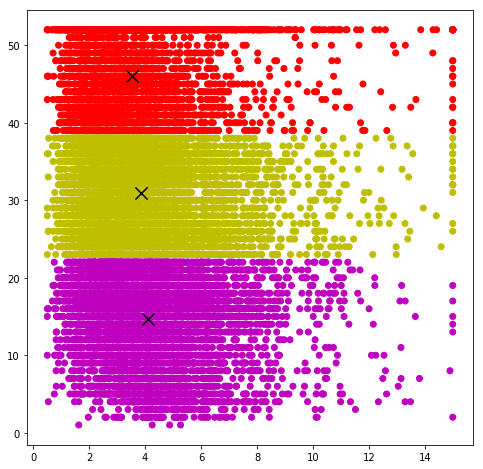

In [28]:
# Copiamos a X las columnas 4 y 5 (Población y Ocupación Media)
X = column(cali.data, 0, 1)

# Crear una instancia del agrupador k-means
km = KMeans(init='random', n_clusters=3)

# Agrupar los puntos en clusters
km.fit(X)

# Podemos consultar el cluster asignado a cada punto y el centro de cada cluster
labels = km.labels_
centers = km.cluster_centers_

plot_clusters(X, labels, centers)

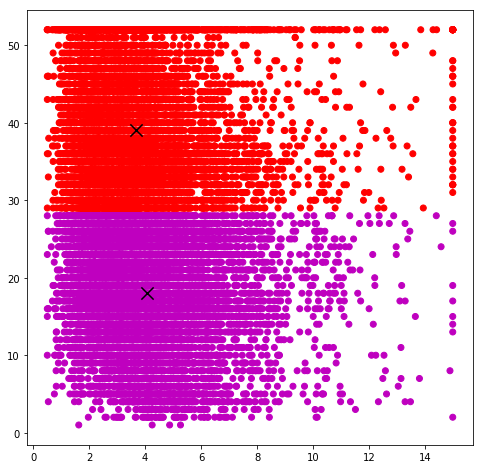

0.5735207485465588


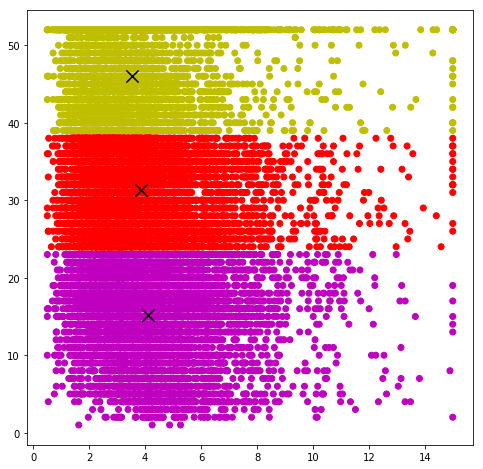

0.5317915014129825


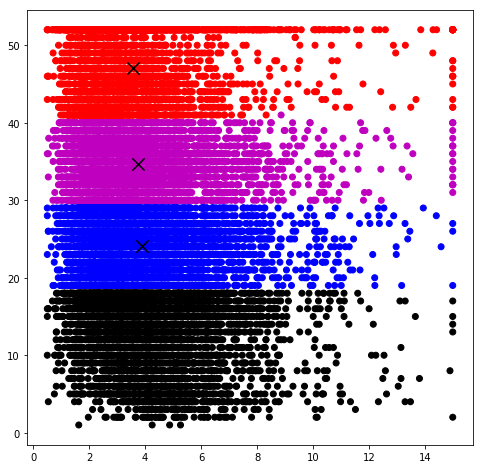

0.49590834765146236


In [29]:
K_MAX = 5
silhouette = np.zeros(K_MAX-2)
for k in range(2, K_MAX): 
    km = KMeans(init='random', n_clusters=k)
    km.fit(X)
    plot_clusters(X, km.labels_, km.cluster_centers_)
    
    silhouette[k-2] = silhouette_score(X, km.labels_) 
    print(silhouette_score(X, km.labels_))

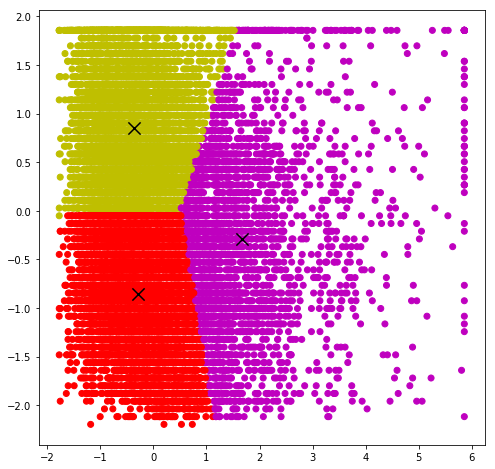

0.39370287961919154


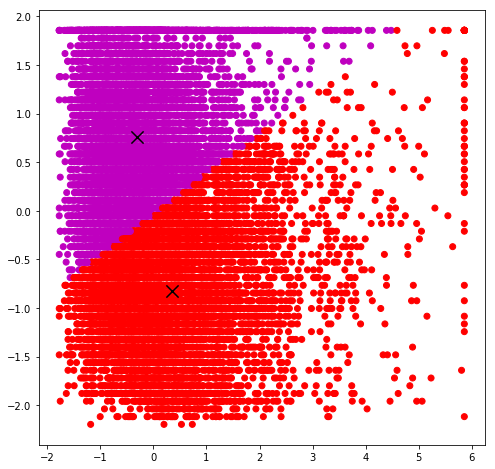

0.3678736004614247


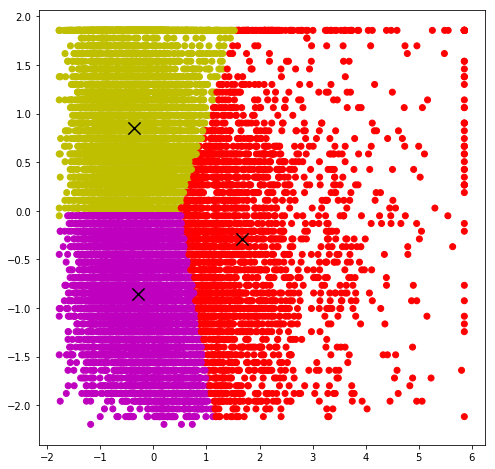

0.39369430009464473


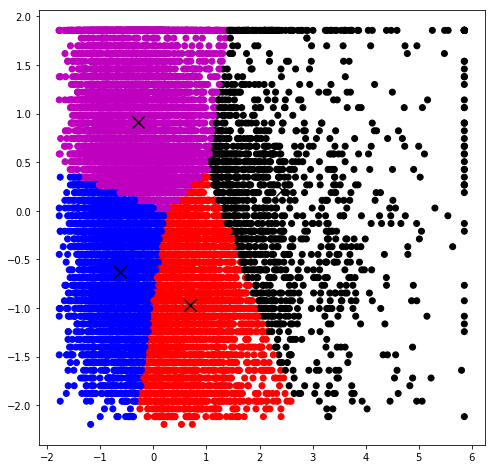

0.3587669876454761


In [31]:
from sklearn.preprocessing import StandardScaler

# Normalizamos los datos para que estén centrados en 0 y con varianza 1
scaler = StandardScaler()
XSCALED = scaler.fit_transform(X)

# Aplicamos ahora k-means
km = KMeans(init='random', n_clusters=3)
km.fit(XSCALED)
plot_clusters(XSCALED, km.labels_, km.cluster_centers_)

print(silhouette_score(XSCALED, km.labels_))


K_MAX = 5
silhouette = np.zeros(K_MAX-2)
for k in range(2, K_MAX): 
    km = KMeans(init='random', n_clusters=k)
    km.fit(XSCALED)
    plot_clusters(XSCALED, km.labels_, km.cluster_centers_)
    
    silhouette[k-2] = silhouette_score(XSCALED, km.labels_) 
    print(silhouette_score(XSCALED, km.labels_))

3) Aplica el algoritmo de clustering k‐medias y determina el número de clusters que consideras adecuado para el conjunto de datos, justificando tu elección.

4) Trata de averiguar qué representa cada uno de los clusters que has obtenido. Si en el apartado anterior has obtenido más de 5 clusters, basta con que comentes los dos más numerosos y los dos menos numerosos. ¿Qué valores toman las variables en cada cluster? Puedes usar estadísticos descriptivos Te recomendamos que uses las variables en su escala original y no en la transformada (ya que se interpretará mucho peor).

5) Pinta los clusters en un gráfico de dispersión en función de dos de las variables de entrada que consideres interesantes. ¿Ves que considerando solamente esas dos variables se diferencien bien algunos de los clusters? ¿Cuáles? Por el contrario, ¿cuáles se confuden más?  Te recomendamos que en este caso uses las variables tal y como las usaste para hacer el clustering (es decir, re‐escaladas, si las re‐escalastes) para así diferenciar los clusters mejor 